#                                                 Project 2 – Wholesale Customer
### Context: The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units on diverse product categories.
#### Task: Goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with.

### 1.Perform EDA and any data cleaning if necessary.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [2]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Read the dataset
# Explore the dataset
customers_df = pd.read_excel("Wholesale customers data.xlsx")
customers_df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Display basic information about the dataset
customers_df.info()
customers_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Text(0.5, 1.0, 'Box Plot of Features After Outlier Replacement')

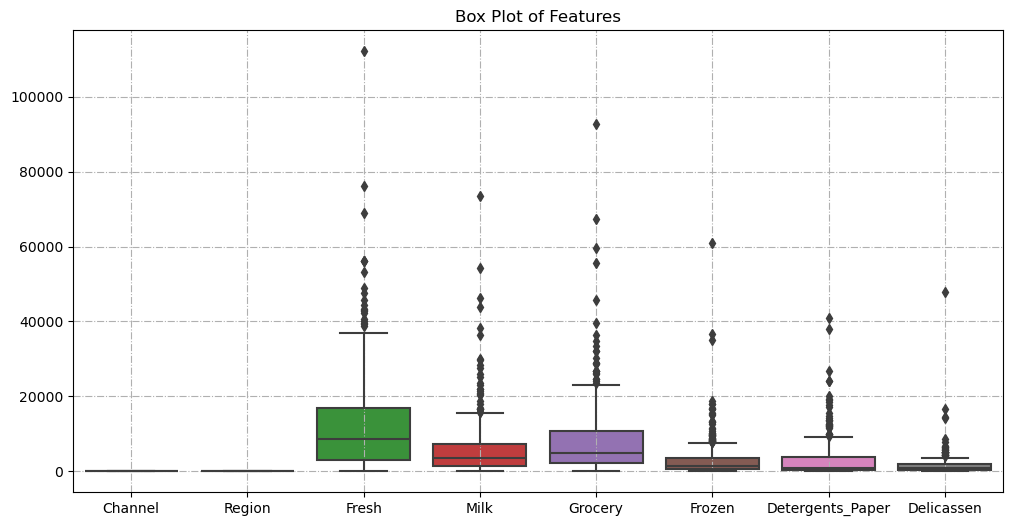

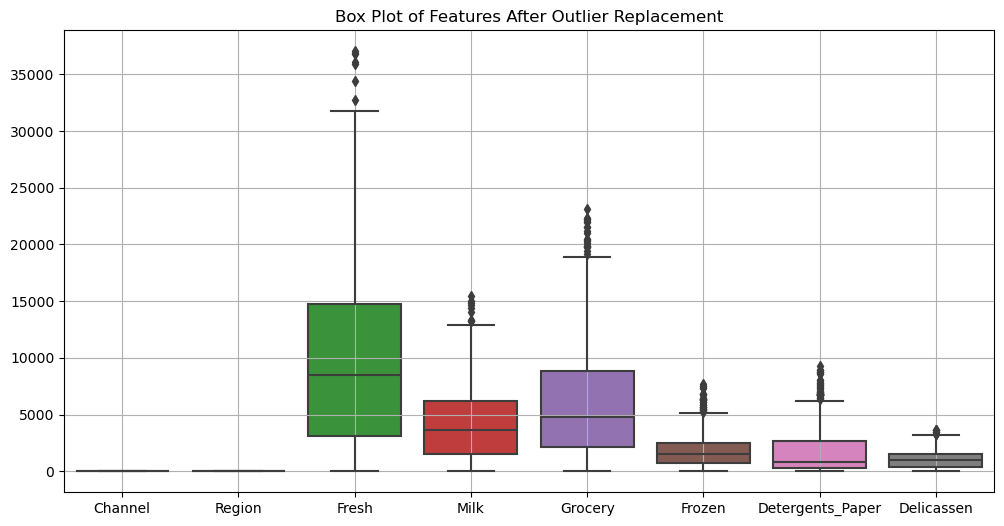

In [5]:
# Create a box plot to identify outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=customers_df)
plt.grid(True, linestyle='-.')
plt.title("Box Plot of Features")

# Define a function to replace outliers with median
def replace_outliers_with_median(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column = column.apply(lambda x: column.median() if x > upper_bound or x < lower_bound else x)
    return column

# Replace outliers with the median for each feature
for feature in customers_df.columns[2:]:  # Start from the 3rd column (skipping 'Channel' and 'Region')
    customers_df[feature] = replace_outliers_with_median(customers_df[feature])

# Box plot after outlier replacement
plt.figure(figsize=(12, 6))
sns.boxplot(data=customers_df)
plt.grid(True)
plt.title("Box Plot of Features After Outlier Replacement")

#### No missing values, outliers replaced

### 2.Implement Feature Scaling to Normalize the data(compare the histogram/KDE for MinMaxScaler and StandardScaler). Choose one of the Scaler to proceed ahead and provide reasoning as to why it was selected?


#### MinMaxScaler:
##### Range adjustment: Scales the data to a specified range (typically [0, 1]).
##### Sensitive to outliers: MinMaxScaler is very sensitive to outliers as it is influenced by extreme values.
##### Use case: Choose MinMaxScaler when you know that the data distribution will not be affected by outliers, or when your model is more sensitive to inputs within a specific range.
#### StandardScaler:
##### Mean normalization: Scales the data to a standard normal distribution with a mean of 0 and standard deviation of 1.
##### Relatively robust to outliers: StandardScaler is relatively robust to outliers as it uses the mean and standard deviation.
##### Use case: Choose StandardScaler when your data distribution is not affected by outliers, and your model is not sensitive to the mean and standard deviation of input features.
##### If your model is distance-based (e.g., K-means, Support Vector Machines), StandardScaler is typically preferred.
##### If your data distribution is not affected by outliers, and your model is more sensitive to inputs within a specific range, you may choose MinMaxScaler.
##### Considering these characteristics, the choice for data normalization method leans towards 'StandardScaler.

In [6]:
# Select numerical features for scaling 
numerical_features = ['Fresh', 'Milk', 'Grocery','Frozen','Detergents_Paper','Delicassen']

In [7]:
# MinMaxScaler
minmax_scaler = MinMaxScaler()
data_minmax = minmax_scaler.fit_transform(customers_df)
df_minmax = pd.DataFrame(data_minmax, columns=customers_df.columns)

# StandardScaler
standard_scaler = StandardScaler()
data_standard = standard_scaler.fit_transform(customers_df)
df_standard = pd.DataFrame(data_standard, columns=customers_df.columns)



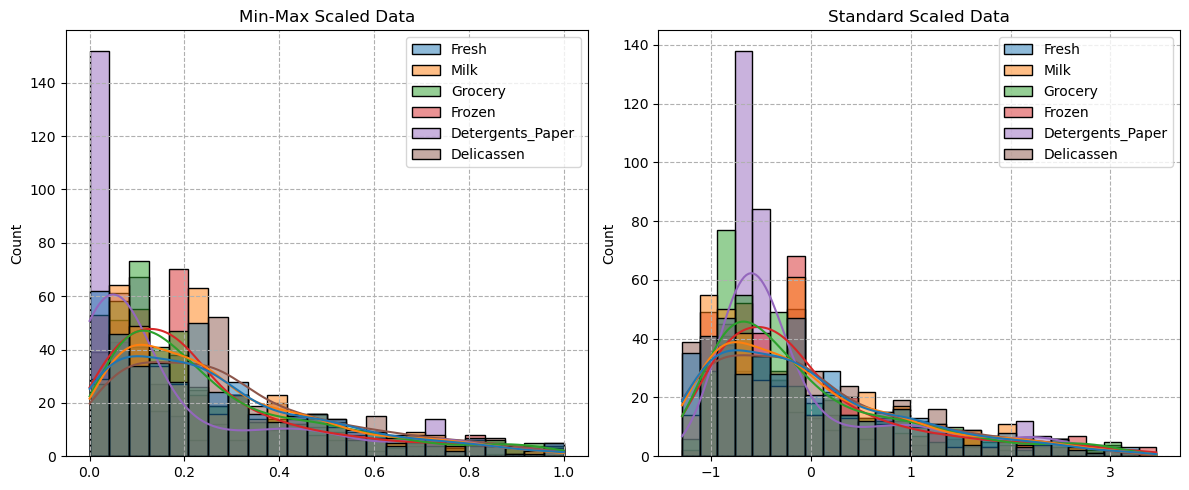

In [8]:
# Histogram and KDE plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_minmax[df_minmax.columns[2:]], kde=True)
plt.grid(True,linestyle='--')
plt.title('Min-Max Scaled Data')

plt.subplot(1, 2, 2)
sns.histplot(data=df_standard[df_standard.columns[2:]], kde=True)
plt.grid(True, linestyle='--')
plt.title('Standard Scaled Data')

plt.tight_layout()
plt.show()



In [9]:
from sklearn import cluster
spectral = cluster.SpectralClustering(
        n_clusters=4, eigen_solver='arpack',
        affinity="nearest_neighbors")

spectral.fit(data_standard)

SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=4)

In [10]:
print(spectral.labels_)

[1 1 1 2 1 1 1 1 3 1 1 1 1 1 1 3 1 3 1 3 1 2 2 1 1 1 2 3 1 3 2 3 2 2 3 1 2
 1 1 2 2 2 1 1 1 1 1 1 1 1 2 3 1 1 2 3 1 1 3 3 1 2 1 1 2 1 3 1 2 3 2 2 3 1
 1 2 2 1 3 3 3 1 1 2 1 1 1 2 3 2 2 2 1 2 1 3 1 3 3 2 1 1 1 2 3 2 1 1 1 1 2
 1 2 2 2 2 3 3 2 2 2 3 2 1 2 3 2 1 3 2 2 3 3 3 3 3 2 3 2 3 2 2 2 3 2 1 3 3
 2 2 2 3 2 3 3 1 1 2 1 1 1 2 2 1 1 1 1 3 3 2 1 1 3 1 2 1 2 2 3 2 2 3 3 2 3
 3 2 2 1 1 2 3 3 1 3 2 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 0 2 3 3 2 3 2 1 3 1 2 2 2 3 3 2 3 3 3 3 2 1 0 1
 0 1 1 3 1 1 1 1 1 1 1 0 0 1 0 2 1 2 0 1 0 0 0 1 3 0 0 3 0 2 0 3 0 0 0 1 0
 1 1 1 0 0 0 0 1 1 3 1 3 3 1 1 3 1 3 1 3 1 2 3 2 1 2 3 2 3 3 3 3 1 3 3 2 3
 1 2 3 1 3 3 1 3 3 1 2 2 2 2 2 2 3 2 3 2 2 3 3 2 3 2 1 2 2 3 2 2 2 2 2 3 2
 1 1 3 3 3 3 2 2 1 1 3 1 3 3 1 2 1 1 2 1 2 3 2 3 3 2 3 3 2 2 1 2 3]


In [11]:
# Let us do minor Pandas manipulation to view clusters in an intuitive way
customers_df['category'] = spectral.labels_
customers_clusters = customers_df.groupby('category').mean()
customers_clusters.index = ['low', 'mid_low', 'mid_high', 'high']
customers_clusters[['Channel','Region','Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper','Delicassen']]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
low,1.036585,1.256098,10806.829268,2819.146341,3877.390244,2545.987805,756.487805,1101.280488
mid_low,1.985714,2.635714,8028.678571,7301.057143,11185.039286,1351.057143,4048.089286,1273.960714
mid_high,1.008929,2.973214,16237.678571,3049.705357,4147.325893,2985.901786,602.834821,1262.495536
high,1.000000,2.962264,5526.037736,2727.547170,3659.886792,964.047170,928.000000,632.372642


In [12]:
clusters = customers_df.groupby('category').Fresh.agg(['mean', 'median', 'std']).sort_values('mean')
clusters.index = ['low', 'mid_low', 'mid_high', 'high']
clusters

,mean,median,std
low,5526.037736,5164.5,4176.702926
mid_low,8028.678571,5803.5,7260.622111
mid_high,10806.829268,8645.5,7853.464125
high,16237.678571,15265.5,9547.485136


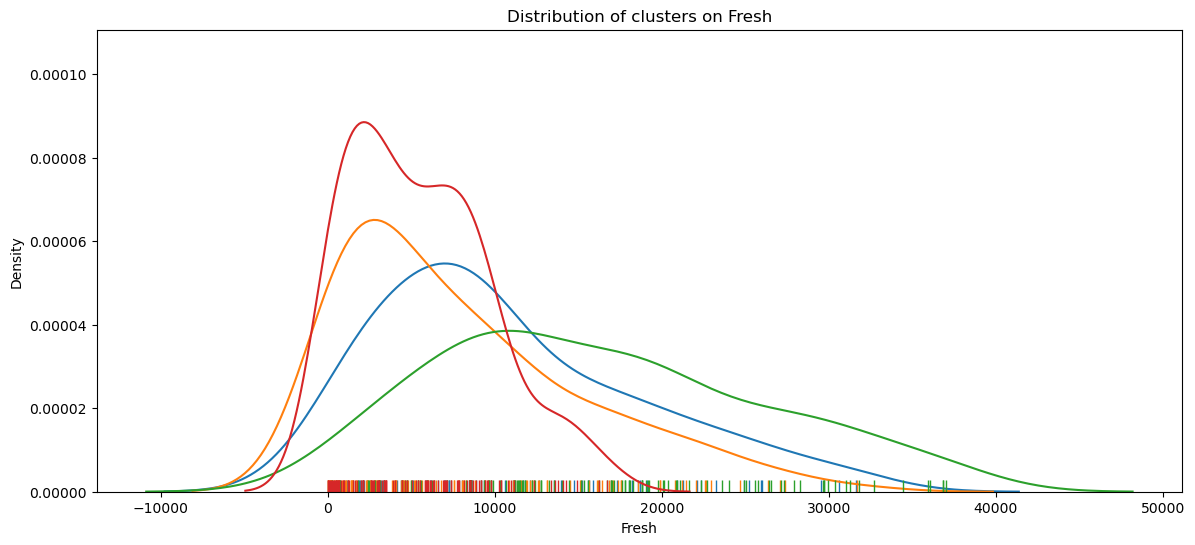

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(14,6))

sns.distplot(customers_df[customers_df.category == 0].Fresh, hist=False, rug=True)
sns.distplot(customers_df[customers_df.category == 1].Fresh, hist=False, rug=True)
sns.distplot(customers_df[customers_df.category == 2].Fresh, hist=False, rug=True)
sns.distplot(customers_df[customers_df.category == 3].Fresh, hist=False, rug=True)
ax.set_title("Distribution of clusters on Fresh");


### 3.Find optimal number of features using RFECV and show the plot between Number of features selected vs Cross validation score (use channel as target variable)

In [14]:
# Assuming X and y are your feature matrix and target variable
X = df_standard.drop('Channel', axis=1)  
y = customers_df['Channel']

In [15]:
rf_model = RandomForestClassifier()
rfecv = RFECV(estimator=rf_model, step=1, cv=5,scoring='accuracy') 
rfecv.fit(X, y)

RFECV(cv=5, estimator=RandomForestClassifier(), scoring='accuracy')

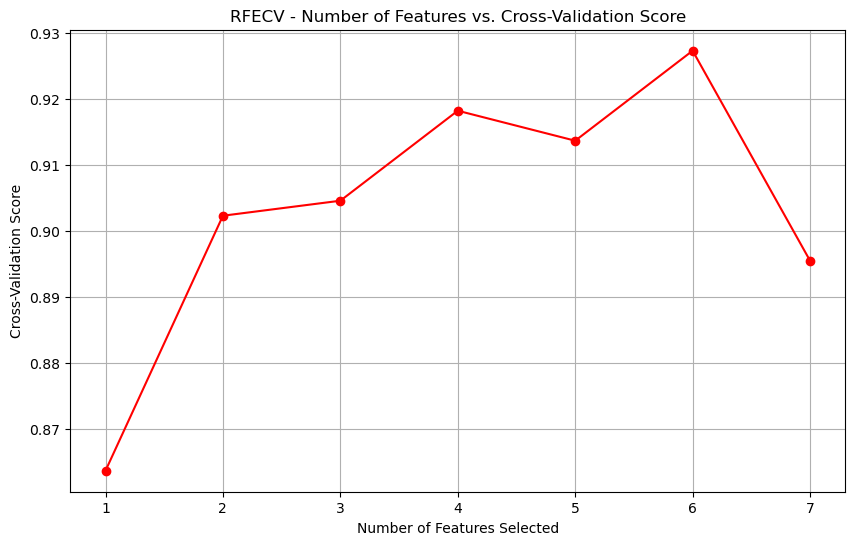

In [16]:
plt.figure(figsize=(10, 6))
plt.title('RFECV - Number of Features vs. Cross-Validation Score')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Score')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o', linestyle='-', color='r')
plt.grid(True)
plt.show()

In [17]:
# Identify the optimal number of features
optimal_num_features = rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

Optimal number of features: 6


### 4.Implement KMeans Clustering for K=2 to K=15 and based on elbow method identify what is the optimum number of clusters

In [18]:
# Elbow Method to find optimal K
wcss = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

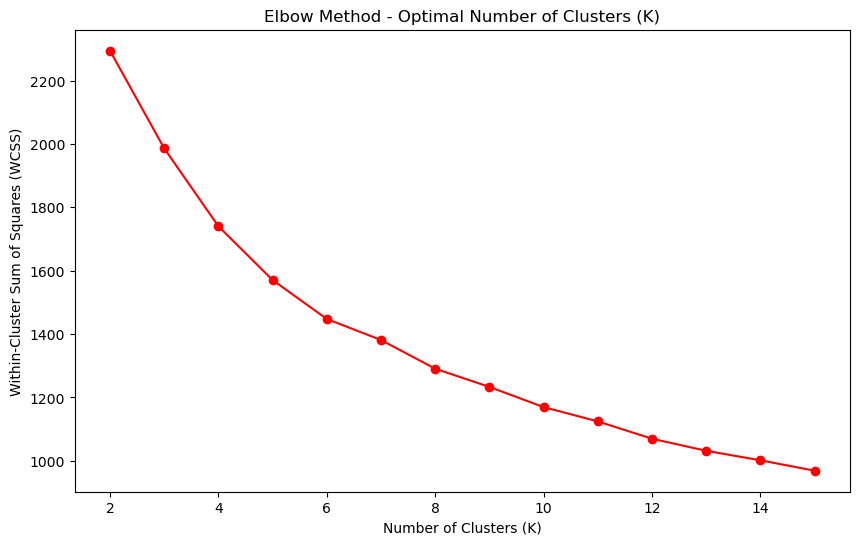

In [19]:
# Plotting the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 16), wcss, marker='o', linestyle='-', color='r')
plt.title('Elbow Method - Optimal Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [20]:
# Based on the plot, select the optimal number of clusters (K)
optimal_k = 4
print(f"Optimal number of clusters (K): {optimal_k}")

Optimal number of clusters (K): 4


### 5.Implement PCA with number of original features to answer how much variance is explained by first 2 components and by first 4 components and visualize the clusters in the data


In [21]:
# Initialize PCA with the optimal number of features
pca = PCA(n_components=X.shape[1])
pca.fit(X)

PCA(n_components=7)

In [22]:
# Check the cumulative explained variance of the principal components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

print(cumulative_explained_variance)

[0.34057011 0.52707322 0.67754974 0.79478911 0.89746708 0.96200085
 1.        ]


In [23]:
# Find out how much variance is explained by the first 2 and 4 components
explained_variance_ratio_2 = np.sum(pca.explained_variance_ratio_[:2])
explained_variance_ratio_4 = np.sum(pca.explained_variance_ratio_[:4])

print(f"Variance explained by first 2 components: {explained_variance_ratio_2}")
print(f"Variance explained by first 4 components: {explained_variance_ratio_4}")

Variance explained by first 2 components: 0.5270732180106164
Variance explained by first 4 components: 0.7947891148440309


In [24]:
comps = pd.DataFrame(pca.components_, columns=X.columns)
comps

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.045017,-0.149386,0.523397,0.571625,-0.183327,0.557541,0.174632
1,-0.191659,0.581355,0.156428,0.077582,0.468417,-0.090908,0.605909
2,-0.847385,-0.401009,0.013565,0.025343,0.316785,0.065600,-0.125089
3,0.408166,-0.078311,0.017979,0.127623,0.786978,0.181725,-0.397868
4,-0.271247,0.670085,0.094754,0.172380,-0.163449,0.081433,-0.636687
5,0.049092,-0.106396,0.816951,-0.261362,0.022605,-0.477347,-0.148929
6,-0.024368,0.111512,0.157136,-0.743149,0.007977,0.639582,0.029680


<Axes: >

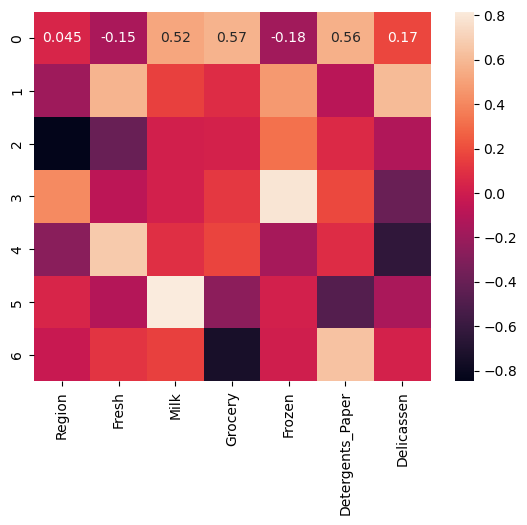

In [25]:
sns.heatmap(comps, annot=True)

### 6.Implement XGBoost Classifier with 5 Fold CV and report the performance metrics

In [26]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [29]:
# Implement XGBoost Classifier with 5-fold CV
model = XGBClassifier()
cv_scores = cross_val_score(model, X, y, cv=5)

In [30]:
# Print cross-validation accuracy
print("Cross-Validation Accuracy: ", cv_scores.mean())
print("\n")

# Print accuracy for each fold
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i} Accuracy: {score}")    
print("\n")
    
# Train the model on the entire dataset
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Report performance metrics
print("Classification Report:\n", classification_report(y, y_pred))

Cross-Validation Accuracy:  0.9022727272727273


Fold 1 Accuracy: 0.9090909090909091
Fold 2 Accuracy: 0.8863636363636364
Fold 3 Accuracy: 0.9090909090909091
Fold 4 Accuracy: 0.8863636363636364
Fold 5 Accuracy: 0.9204545454545454


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       298
           1       1.00      1.00      1.00       142

    accuracy                           1.00       440
   macro avg       1.00      1.00      1.00       440
weighted avg       1.00      1.00      1.00       440



##### The accuracy is about 90.2%. The overall accuracy is 1, indicating that the model achieves perfect accuracy. XGBoost classification models exhibit high accuracy and excellent performance.